In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import commonfunc

In [3]:
data_set_path = "./sampled_data_csv_100/"

# Chartevents

## Read samples

In [6]:
chartevents_df = commonfunc.read_csv_no_rowid(data_set_path + "chartevents.csv")
chartevents_df = chartevents_df.sample(n=2000)

## Data preproces

In [7]:
# Drop useless colums
chartevents_df.drop(['subject_id', 'hadm_id', 'cgid', 'valuenum', 'valueuom', 'warning', 'error', 'resultstatus', 'stopped'], axis=1, inplace=True)

### Process null values

In [8]:
# Drop some null value
chartevents_df.dropna(subset=['icustay_id'], inplace=True, axis=0)

In [10]:
commonfunc.nan_count(chartevents_df)

Total columns: 5
Total rows: 1995
--------------
icustay_id     0
itemid         0
charttime      0
storetime      0
value         13
dtype: int64


In [11]:
chartevents_df['value'].fillna(value='Na', inplace=True)

### Set the column types

In [12]:
chartevents_df.dtypes

icustay_id    float64
itemid          int64
charttime      object
storetime      object
value          object
dtype: object

In [13]:
# Transfer some date type
# chartevents_df['subject_id'] = chartevents_df['subject_id'].astype(str)
# chartevents_df['hadm_id'] = chartevents_df['hadm_id'].astype(str)
# chartevents_df['icustay_id'] = chartevents_df['icustay_id'].astype(str)

# chartevents_df['itemid'] = chartevents_df['itemid'].astype(str)

chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])
chartevents_df['storetime'] = pd.to_datetime(chartevents_df['storetime'])

In [14]:
chartevents_df.dtypes

icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
storetime     datetime64[ns]
value                 object
dtype: object

### Process time value

In [16]:
icustays_df = commonfunc.read_csv_no_rowid(data_set_path+"icustays.csv")

In [17]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [18]:
chartevents_mid_df = pd.merge(left=chartevents_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [19]:
chartevents_mid_df.dtypes

icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
storetime     datetime64[ns]
value                 object
intime        datetime64[ns]
dtype: object

In [21]:
chartevents_mid_df['storetime'] = chartevents_mid_df.apply(commonfunc.time_process, args=('charttime', 'storetime'), axis=1)
chartevents_mid_df['charttime'] = chartevents_mid_df.apply(commonfunc.time_process, args=('intime', 'charttime'), axis=1)

In [22]:
chartevents_mid_df

,icustay_id,itemid,charttime,storetime,value,intime
0,289784.0,207,1474440.0,1440.0,16 French,2177-10-04 14:26:00
1,255260.0,216,96023.0,900.0,15 degrees,2106-03-20 16:19:37
2,244176.0,680,3541080.0,15240.0,AirMatt/1st Step,2132-07-04 01:22:00
3,241691.0,506,2429812.0,780.0,10,2162-10-03 17:03:08
4,245357.0,5815,101206.0,480.0,50,2117-11-25 09:53:14
...,...,...,...,...,...,...
1990,260285.0,620,670200.0,540.0,Nail Bed,2167-12-21 19:50:00
1991,257517.0,8549,1256143.0,11040.0,135,2188-09-23 22:04:17
1992,241691.0,218,67012.0,360.0,45,2162-10-03 17:03:08
1993,289784.0,346,2669640.0,10260.0,Blister,2177-10-04 14:26:00


In [23]:
chartevents_df = chartevents_mid_df.drop(['icustay_id', 'intime'], axis=1)

In [24]:
chartevents_df.columns

Index(['itemid', 'charttime', 'storetime', 'value'], dtype='object')

---

##  Build Network

### Set constraints

In [25]:
from sdv.constraints import FixedCombinations

fixed_item_value_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [26]:
constraints = [fixed_item_value_constraint]

In [28]:
train_data = chartevents_df
best_model = commonfunc.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 36695.98it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 34419.99it/s]


CTGAN


Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 5063.34it/s]


CopulaGAN


Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 18532.72it/s]


TVAE


Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 22439.96it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 41168.78it/s]


The best model is: copulagan
The ContinuousKL_score is: 0.714003358060503
The DiscreteKL_score is: nan
The total score is: 0.618613467616939


In [30]:
model_save_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "chartevents_model.pkl"
commonfunc.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [32]:
# Load model
date_load_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "chartevents_model.pkl"
model = commonfunc.load_model(date_load_path)

In [33]:
sample = model.sample(num_rows=len(chartevents_df))

Sampling rows: 100%|██████████| 1995/1995 [00:00<00:00, 27391.68it/s]


### Post-process

In [34]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [35]:
def format_values(df):
    if is_number(df['value']):
        return round(float(df['value']), 2)
    else:
        return df['value']


In [36]:
sample['value'] = sample.apply(format_values, axis=1)
sample['value'] = sample['value'].astype(str)

### Evaluation

In [37]:
from sdv.evaluation import evaluate

In [38]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.7197555884624735

In [39]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [40]:
evaluate(sample, train_data, metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence'])

0.49149190737665854

<Axes: >

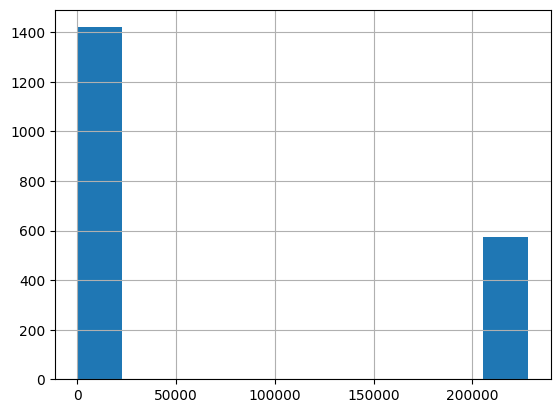

In [41]:
sample.sort_values('itemid')['itemid'].hist()

<Axes: >

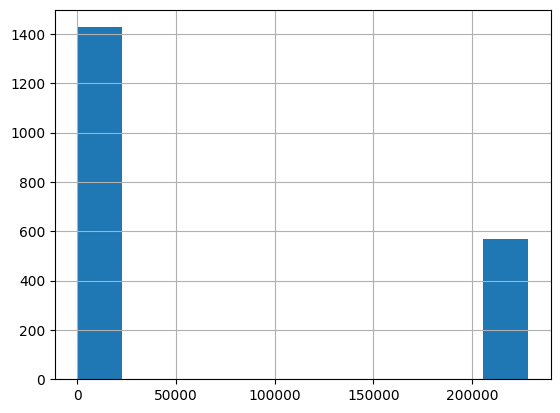

In [42]:
train_data.sort_values('itemid')['itemid'].hist()

<Axes: >

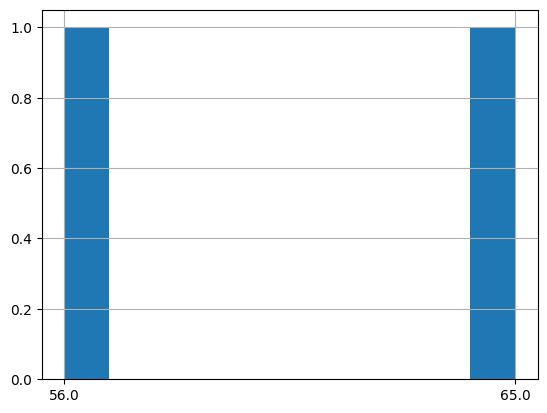

In [43]:
sample.loc[sample['itemid'] == 220052]['value'].hist()

<Axes: >

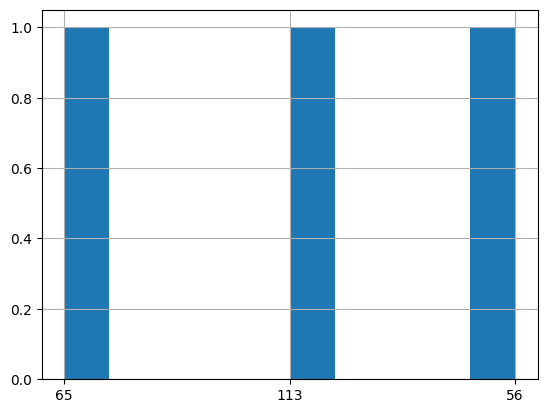

In [44]:
train_data.loc[train_data['itemid'] == 220052]['value'].hist()